In [1]:
import numpy as np

## Get data

In [2]:
vocab = catalog.load('dictionary')
train_docs = catalog.load('train_docs')
train_sparse = catalog.load('train_sparse')
val_docs = catalog.load('val_docs')
val_sparse = catalog.load('val_sparse')

2020-04-03 12:03:45,648 - kedro.io.data_catalog - INFO - Loading data from `dictionary` (DictionaryDataSet)...
2020-04-03 12:03:45,650 - gensim.utils - INFO - loading Dictionary object from data/05_model_input/dictionary.dict
2020-04-03 12:03:45,652 - gensim.utils - INFO - loaded data/05_model_input/dictionary.dict
2020-04-03 12:03:45,653 - kedro.io.data_catalog - INFO - Loading data from `train_docs` (PickleLocalDataSet)...
2020-04-03 12:03:45,876 - kedro.io.data_catalog - INFO - Loading data from `train_sparse` (ScipySparseMatrix)...
2020-04-03 12:03:45,917 - kedro.io.data_catalog - INFO - Loading data from `val_docs` (PickleLocalDataSet)...
2020-04-03 12:03:45,959 - kedro.io.data_catalog - INFO - Loading data from `val_sparse` (ScipySparseMatrix)...


In [3]:
def split_bow(bow_in, n_docs):
    indices = [np.array([w for w in bow_in[doc,:].indices], ndmin=2) for doc in range(n_docs)]
    counts = [np.array([c for c in bow_in[doc,:].data], ndmin=2) for doc in range(n_docs)]
    return indices, counts

In [4]:
vocab_size = len(vocab)
num_docs_train = len(train_docs)
num_docs_val = len(val_docs)
train_tokens, train_counts = split_bow(train_sparse, num_docs_train)
val_tokens, val_counts = split_bow(val_sparse, num_docs_val)

del train_docs
del train_sparse
del val_docs
del val_sparse

## Get embeddings

In [5]:
dict_embeddings_norm = catalog.load('dict_embeddings_norm')
flag_pretrained_embeddings = False

2020-04-03 12:03:52,138 - kedro.io.data_catalog - INFO - Loading data from `dict_embeddings_norm` (PickleLocalDataSet)...


In [6]:
embeddings = None
if flag_pretrained_embeddings:
    #embeddings = np.zeros((vocab_size, embedding_size))
    embeddings = []
    for i, word in enumerate(vocab.token2id):
        #embeddings[i] = dict_embeddings_norm[word]
        if word in dict_embeddings_norm:
            embeddings.append(dict_embeddings_norm[word])
        else:
            embeddings.append(np.random.normal(0., 0.01, (300,)))
    embeddings = np.array(embeddings)

## Get model

In [7]:
import torch
import torch.nn.functional as F
from torch import nn, optim

# K = num_topics
# V = vocab_size
# M = embedding_size
# D = num_documents

# rho = word embeddings matrix (M, V)
# alpha_k = topic embedding (M, 1)
# alpha = topic embeddings matrix (M, K)
# theta_d = topic proportion for doc d (K, 1)
# theta = topic proportions matrix (K, D)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ETM(nn.Module):
    def __init__(self, num_topics=50, vocab_size=300, embedding_size=300, flag_finetune_embeddings=False,
                 embeddings=None, t_hidden_size=800, theta_act='relu', enc_drop=0.0):
        super(ETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.t_hidden_size = t_hidden_size

        ## define the word embedding matrix \rho        
        if embeddings is not None:
            embeddings = torch.from_numpy(embeddings).clone().float().to(device)
            if flag_finetune_embeddings:
                self.rho = nn.Embedding.from_pretrained(embeddings, freeze=False)
            else:
                self.rho = nn.Embedding.from_pretrained(embeddings, freeze=True)
        else:
            self.rho = nn.Linear(embedding_size, vocab_size, bias=False)
            
        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(embedding_size, num_topics, bias=False)
        
        ## define variational distribution for \theta_{1:D} via amortizartion
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size),
                self.get_activation(theta_act),
                nn.Linear(t_hidden_size, t_hidden_size),
                self.get_activation(theta_act),
                nn.Dropout(enc_drop)
            )
        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def get_activation(self, act):
        if act == 'tanh':
            act = nn.Tanh()
        elif act == 'relu':
            act = nn.ReLU()
        else:
            print('Defaulting to tanh activations...')
            act = nn.Tanh()
        return act
    
    # beta = Softmax(rho.T x alpha)
    def get_beta(self):
        logit = self.alphas(self.rho.weight)
        beta = F.softmax(logit, dim=0).transpose(1, 0)
        return beta

    # (mu, sigma) = NeuralNetwork (with variational params)
    # delta ~ N(mu, sigma) (re-parameterization trick)
    # theta = Softmax(delta)
    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            return mu
        
    def encode(self, corpus):
        q_theta = self.q_theta(corpus)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)
        return mu_theta, logsigma_theta
    
    def get_theta(self, normalized_corpus):
        mu_theta, logsigma_theta = self.encode(normalized_corpus)
        delta = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(delta, dim=-1)
        KL_p_q = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()
        return theta, KL_p_q

    # log p(w_dn | theta) = log(sum(theta.T x beta))
    def decode(self, theta, beta, eps=1e-6):
        p_w = torch.mm(theta, beta)
        log_p_w = torch.log(p_w + eps)
        return log_p_w

    # loss: ELBO(q) = E[log p(w|z)] - KL(p(z)||q(z))
    def forward(self, corpus, normalized_corpus):
        # get theta
        theta, KL_p_q = self.get_theta(normalized_corpus)
        
        # get beta
        beta = self.get_beta()
        
        log_p_w = self.decode(theta, beta)
        E_log_p_w = -(log_p_w * corpus).sum(1)
        E_log_p_w = E_log_p_w.mean()
        #ELBO = 
        #loss = 
        return E_log_p_w, KL_p_q

In [8]:
num_topics = 15
embedding_size = 300
flag_finetune_embeddings = False

model = ETM(num_topics=num_topics, vocab_size=vocab_size, embedding_size=embedding_size, 
            flag_finetune_embeddings=flag_finetune_embeddings, embeddings=embeddings)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ETM(
  (rho): Linear(in_features=300, out_features=2715, bias=False)
  (alphas): Linear(in_features=300, out_features=15, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=2715, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
  )
  (mu_q_theta): Linear(in_features=800, out_features=15, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=15, bias=True)
)


## Train model

In [9]:
def get_batch(tokens, counts, ind, vocab_size, device, emsize=300):
    """fetch input data by batch."""
    batch_size = len(ind)
    data_batch = np.zeros((batch_size, vocab_size))

    for i, doc_id in enumerate(ind):
        doc = tokens[doc_id]
        count = counts[doc_id]
        L = count.shape[1]
        if len(doc) == 1:
            doc = [doc.squeeze()]
            count = [count.squeeze()]
        else:
            doc = doc.squeeze()
            count = count.squeeze()
        if doc_id != -1:
            for j, word in enumerate(doc):
                data_batch[i, word] = count[j]
    data_batch = torch.from_numpy(data_batch).float().to(device)
    return data_batch

def train_step(model, optimizer, num_docs_train, train_tokens, train_counts, vocab_size, device, epoch=10, batch_size=1000):
    model.train()

    acc_loss = 0
    acc_kl_theta_loss = 0
    cnt = 0

    indices = torch.randperm(num_docs_train)
    indices = torch.split(indices, batch_size)
    for idx, ind in enumerate(indices):

        optimizer.zero_grad()
        model.zero_grad()

        data_batch = get_batch(train_tokens, train_counts, ind, vocab_size, device)

        sums = data_batch.sum(1).unsqueeze(1)
        normalize_batch = True
        if normalize_batch:
            normalized_data_batch = data_batch / sums
        else:
            normalized_data_batch = data_batch

        E_log_p_w, KL_p_q = model(data_batch, normalized_data_batch)
        total_loss = E_log_p_w + KL_p_q
        total_loss.backward()

        clip = 0
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        acc_loss += torch.sum(E_log_p_w).item()
        acc_kl_theta_loss += torch.sum(KL_p_q).item()
        cnt += 1

        #log_interval = 2
        #if idx % log_interval == 0 and idx > 0:
            #cur_loss = round(acc_loss / cnt, 2)
            #cur_kl_theta = round(acc_kl_theta_loss / cnt, 2)
            #cur_real_loss = round(cur_loss + cur_kl_theta, 2)

            #print('Epoch: {} .. batch: {}/{} .. LR: {} .. KL_theta: {} .. Rec_loss: {} .. NELBO: {}'.format(
            #    epoch, idx, len(indices), optimizer.param_groups[0]['lr'], cur_kl_theta, cur_loss, cur_real_loss))

    cur_loss = round(acc_loss / cnt, 2)
    cur_kl_theta = round(acc_kl_theta_loss / cnt, 2)
    cur_real_loss = round(cur_loss + cur_kl_theta, 2)
    print('*'*100)
    print('Epoch----->{} .. LR: {} .. KL_theta: {} .. Rec_loss: {} .. NELBO: {}'.format(
            epoch, optimizer.param_groups[0]['lr'], cur_kl_theta, cur_loss, cur_real_loss))
    print('*'*100)

def train(model, optimizer, num_docs_train, train_tokens, train_counts, vocab_size, device, epochs=10, batch_size=1000, visualize_every=10):
    #best_epoch = 0
    #best_val_ppl = 1e9
    #all_val_ppls = []
    #print('\n')
    #print('Visualizing model quality before training...')
    #visualize(model)
    #print('\n')
    for epoch in range(1, epochs):
        train_step(model, optimizer, num_docs_train, train_tokens, train_counts, vocab_size, device, epoch, batch_size)
        #val_ppl = evaluate(model, 'val')
        #if epoch % visualize_every == 0:
            #visualize(model)
        #all_val_ppls.append(val_ppl)
    model = model.to(device)
    #val_ppl = evaluate(model, 'val')

In [10]:
epochs = 100
batch_size = 1000
lr = 5e-3
wdecay = 1.2e-6

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wdecay)
train(model, optimizer, num_docs_train, train_tokens, train_counts, vocab_size, device, epochs, batch_size)

****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.03 .. Rec_loss: 820.34 .. NELBO: 820.37
****************************************************************************************************
****************************************************************************************************
Epoch----->2 .. LR: 0.005 .. KL_theta: 0.06 .. Rec_loss: 798.59 .. NELBO: 798.65
****************************************************************************************************
****************************************************************************************************
Epoch----->3 .. LR: 0.005 .. KL_theta: 0.14 .. Rec_loss: 801.23 .. NELBO: 801.37
****************************************************************************************************
****************************************************************************************************
Epoch----->4 .. LR: 0.005 .. KL_theta: 0.23 .. Rec

****************************************************************************************************
Epoch----->30 .. LR: 0.005 .. KL_theta: 5.79 .. Rec_loss: 759.56 .. NELBO: 765.35
****************************************************************************************************
****************************************************************************************************
Epoch----->31 .. LR: 0.005 .. KL_theta: 5.83 .. Rec_loss: 769.73 .. NELBO: 775.56
****************************************************************************************************
****************************************************************************************************
Epoch----->32 .. LR: 0.005 .. KL_theta: 5.95 .. Rec_loss: 758.87 .. NELBO: 764.82
****************************************************************************************************
****************************************************************************************************
Epoch----->33 .. LR: 0.005 .. KL_theta: 5.88 ..

****************************************************************************************************
Epoch----->59 .. LR: 0.005 .. KL_theta: 7.23 .. Rec_loss: 744.19 .. NELBO: 751.42
****************************************************************************************************
****************************************************************************************************
Epoch----->60 .. LR: 0.005 .. KL_theta: 7.31 .. Rec_loss: 739.82 .. NELBO: 747.13
****************************************************************************************************
****************************************************************************************************
Epoch----->61 .. LR: 0.005 .. KL_theta: 7.35 .. Rec_loss: 745.36 .. NELBO: 752.71
****************************************************************************************************
****************************************************************************************************
Epoch----->62 .. LR: 0.005 .. KL_theta: 7.39 ..

****************************************************************************************************
Epoch----->88 .. LR: 0.005 .. KL_theta: 8.37 .. Rec_loss: 744.32 .. NELBO: 752.69
****************************************************************************************************
****************************************************************************************************
Epoch----->89 .. LR: 0.005 .. KL_theta: 8.43 .. Rec_loss: 742.72 .. NELBO: 751.15
****************************************************************************************************
****************************************************************************************************
Epoch----->90 .. LR: 0.005 .. KL_theta: 8.36 .. Rec_loss: 736.29 .. NELBO: 744.65
****************************************************************************************************
****************************************************************************************************
Epoch----->91 .. LR: 0.005 .. KL_theta: 8.42 ..

In [16]:
beta = model.get_beta().cpu().detach().numpy()

data_batch = get_batch(train_tokens, train_counts, torch.randperm(10000), vocab_size, device)
sums = data_batch.sum(1).unsqueeze(1)
norm_corpus = data_batch / sums
mu_theta, logsigma_theta = model.encode(norm_corpus)
theta = mu_theta.cpu().detach().numpy()

## Eval model

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import jensenshannon
from sklearn.manifold import MDS

def extract_top_n_words(topic_distributions, dictionary, topic_id, top_n):
    top_n_words = [dictionary[np.argsort(topic_distributions[topic_id])[-i-1]] for i in range(top_n)]
    top_n_freqs = [np.sort(topic_distributions[topic_id])[-i-1] for i in range(top_n)]
    return top_n_words, top_n_freqs

def calculate_topic_distances(topic_distributions):
    num_topics = len(topic_distributions)
    distances = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            topic_i, topic_j = topic_distributions[i], topic_distributions[j]
            distances[i][j] = jensenshannon(topic_i, topic_j)
    return distances

def show_most_m_represantative_docs(doc_topic, m, docs, topic_id):
    indices_max = np.argsort(doc_topic[:,topic_id])[-m:]
    verbatims = []
    for idx in reversed(indices_max):
        doc = docs[idx]
        verbatims.append(' '.join(list(doc)))
    return verbatims

def occ_dict(doc):
    occurences_dict = {}
    for word in doc:
        if word in occurences_dict:
            occurences_dict[word] += 1
        else:
            occurences_dict[word] = 1
    return occurences_dict

def get_Dwi(wi, doc_dicts):
    Dwi = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict:
            Dwi += doc_dict[wi]
    return Dwi

def get_Dwiwj(wi, wj, doc_dicts):
    Dwiwj = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict and wj in doc_dict:
            Dwiwj += doc_dict[wi] * doc_dict[wj]
    return Dwiwj

def topic_coherence(topic_distributions, dictionary, topic_id, top_n, docs, method='umass', eps=1e-5):
    top_words, _ = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n)

    N = top_n - 1

    D = 0
    for doc in docs:
        D += len(doc)
    #D = len(docs)

    # remplacer par un CountVectorizer
    doc_dicts = [occ_dict(doc) for doc in docs]

    score = 0.
    for i in range(1, N):
        for j in range(i):
            wi = top_words[i]
            wj = top_words[j]

            Dwj = get_Dwi(wj, doc_dicts)
            Dwiwj = get_Dwiwj(wi, wj, doc_dicts)

            pwj = Dwj / D
            pwiwj = Dwiwj / D

            # umass
            if method == 'umass':
                score += np.log((pwiwj + eps) / pwj)

            # pmi
            elif method == 'pmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D
                score += np.log((pwiwj + eps) / (pwi * pwj))

            # npmi
            elif method == 'npmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D

                if Dwiwj == 0:
                    score += -1.
                elif Dwiwj == Dwi and Dwiwj == Dwj:
                    score += 1.
                else:
                    score += np.log((pwiwj + eps) / (pwi * pwj)) / (- np.log(pwiwj + eps))

    return score / (2 * N * (N - 1))

def topic_diversity(topic_distributions, dictionary, top_n):
    top_words = []
    num_topics = len(topic_distributions)
    for k in range(num_topics):
        tmp, _ = extract_top_n_words(topic_distributions, dictionary, k, top_n)
        top_words += tmp
    return len(np.unique(top_words)) / len(top_words)

In [18]:
def eval_model(topic_distributions, doc_topic_matrix, dictionary, train_docs,
               num_topics, top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25):

    # Metrics

    ## Qualitative Metrics

    ### Top-n words per topic
    for topic_id in range(num_topics):
        top_n_words, top_n_freqs = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n_show)

        plt.figure(figsize=(10, 4))
        plt.title('Topic number ' + str(topic_id))
        plt.bar(top_n_words, top_n_freqs)
        plt.show()

    ### Topic sizes
    #

    ### Topic distances
    distances = calculate_topic_distances(topic_distributions)
    plt.figure(figsize=(6, 6))
    plt.imshow(distances, cmap='Greys')
    plt.show()

    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(distances).embedding_
    plt.figure(figsize=(6, 6))
    plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0)
    plt.show()

    ### Most m representative documents
    for topic_id in range(num_topics):
        print('Topic number ', topic_id, show_most_m_represantative_docs(doc_topic_matrix, m_most, train_docs, topic_id))


    ## Quantitative Metrics

    ### Topic Coherence
    mean_tc = 0.
    for topic_id in range(num_topics):
        tc = topic_coherence(topic_distributions, dictionary, topic_id, top_n_coherence, train_docs, method='npmi')
        print('Topic number ', topic_id, 'tc:', tc)
        mean_tc += tc
    print('Topic coherence:', mean_tc / num_topics)

    ### Topic Diversity
    print('Topic diversity', topic_diversity(topic_distributions, dictionary, top_n_diversity))

    ### Predictive Quality
    #

In [19]:
train_docs = catalog.load('train_docs')

2020-04-03 12:19:56,777 - kedro.io.data_catalog - INFO - Loading data from `train_docs` (PickleLocalDataSet)...


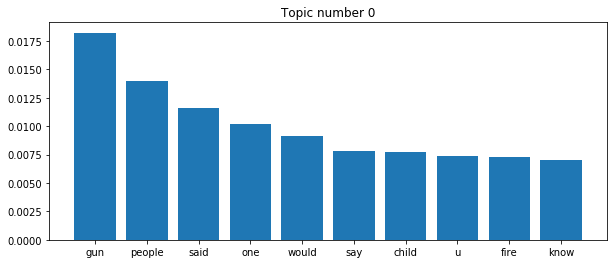

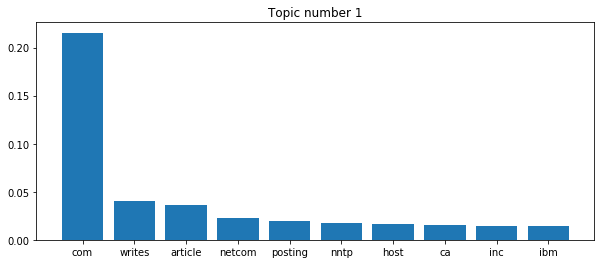

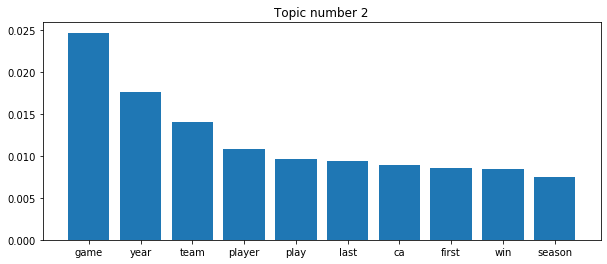

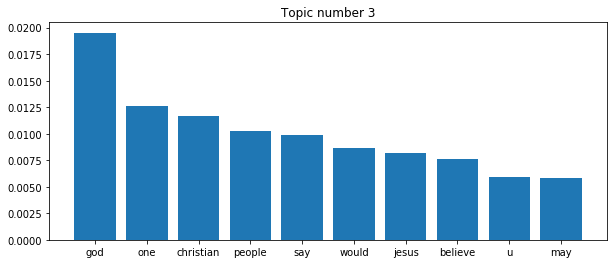

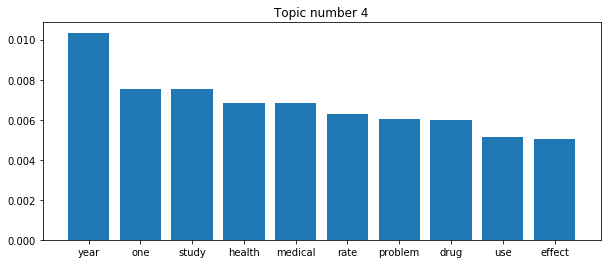

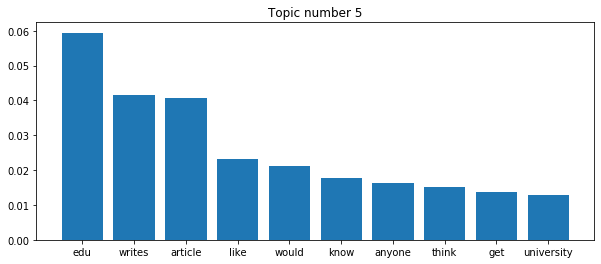

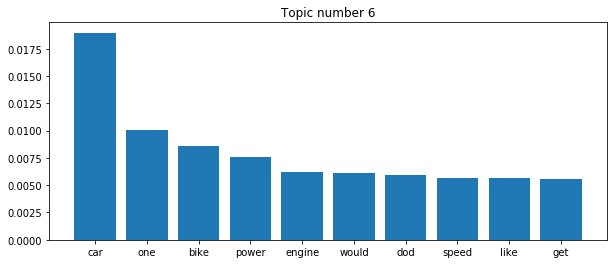

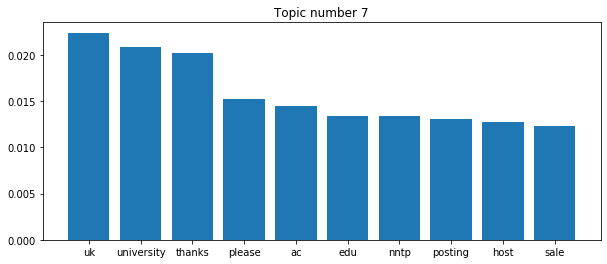

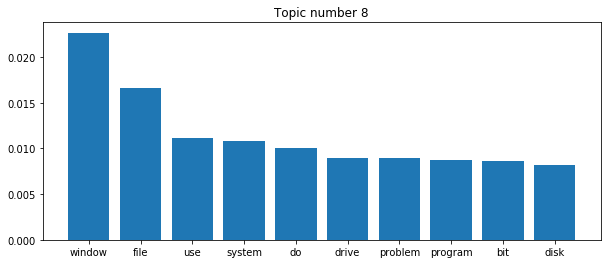

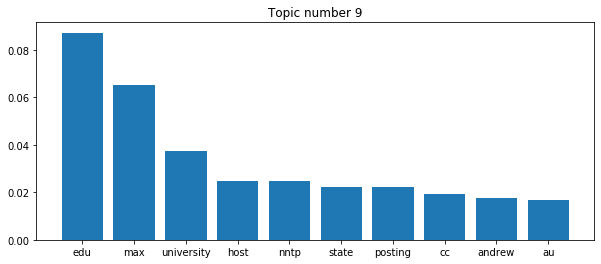

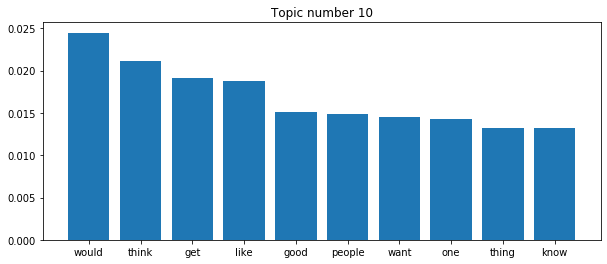

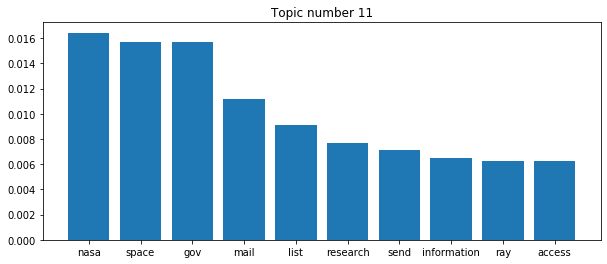

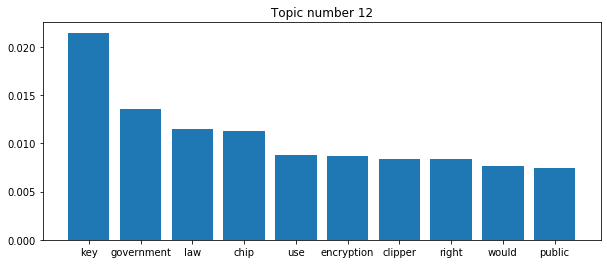

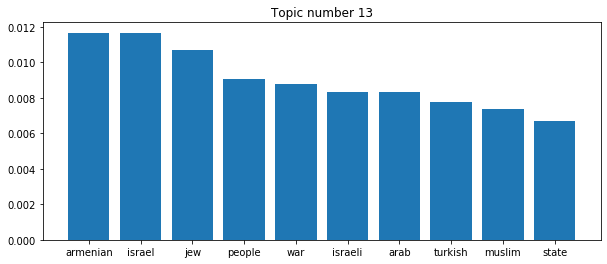

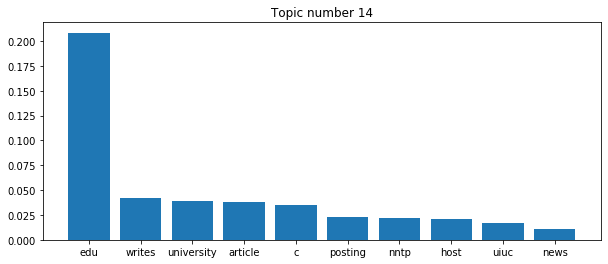

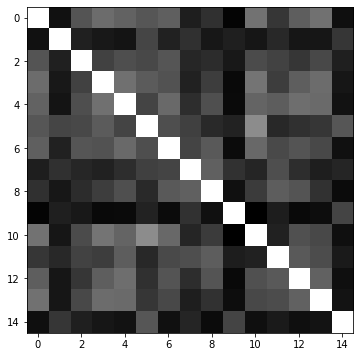

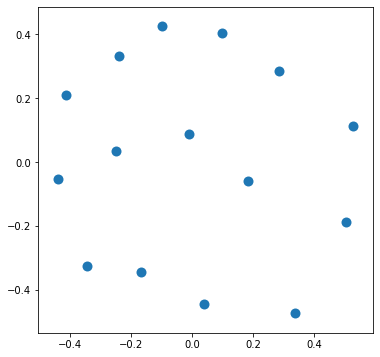

Topic number  0 ['u com michael nntp posting host u com corporation ca distribution usa disclaimer message written user corporation opinion expressed user necessarily article 1993apr14 com com writes article netcom com phil netcom com phil writes correct quite way report woman via power office dozen today call immediate kind guess woman sex much worse national starting secret war kill hundred thousand using power office personal gain like really charge obvious lie challenge present u evidence national never mind used power office personal gain absolutely evidence event along relation relation must government failed attempt course sad level historical political probably best fact think stand instead red']
Topic number  1 ['roger nntp posting host ltd really feel need hockey explain year playoff mean obviously superior toronto team best center best league keep losing give stand made vice president dan sam nick ca']
Topic number  2 ['bnr ca nick respect nntp posting host bnr europe ltd uk

Topic number  0 tc: 0.315911761152944
Topic number  1 tc: 0.20477064437114403
Topic number  2 tc: 0.2603795899793239
Topic number  3 tc: 0.3309383256170757
Topic number  4 tc: 0.2674567759726441
Topic number  5 tc: 0.2664240828098552
Topic number  6 tc: 0.21414448402479583
Topic number  7 tc: 0.20909998688529946
Topic number  8 tc: 0.36996496400875356
Topic number  9 tc: 0.18868055669657152
Topic number  10 tc: 0.31107581465247414
Topic number  11 tc: 0.28588073231852207
Topic number  12 tc: 0.2852604184913638
Topic number  13 tc: 0.2719084188155166
Topic number  14 tc: 0.22539826536684882
Topic coherence: 0.2671529880775422
Topic diversity 0.656


In [20]:
eval_model(beta, theta, vocab, train_docs, num_topics, 
           top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25)